<a href="https://colab.research.google.com/github/Harvard-Neutrino/IceCube_MasterClass_at_Harvard2025/blob/main/cosmic_watch_activities/CosmicWatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cosmic Watch Analysis Notebook

Welcome to the Cosmic Watch Analysis Notebook! This file is what is known as a **Jupyter notebook**. Jupyter notebooks are essentially small snippits of code, called cells. Sometimes these cells just run code, but often the cell will produce an output that can be viewed right in the notebook. In this notebook, we have outputs that are both text and plots!

Jupyter notebooks are a popular way to analyze and visualize data, and we'll use it to take a look at the data you took with the CosmicWatches! For now, the large majority of the code has been written for you and you will just need to tell the notebook where to find the data. Later this afternoon, you'll take a stab at writing your own code in a notebook.

Let's get started!

## Setting Up Your Notebook
We first start by *importing packages* and *defining functions to use*.

**TLDR**: Run the cells below by hitting the "play" button in the top left of each cell. This sets up the code you will need in the following sections.

**Explanation**:

At the most basic level, functions do something to some inputs you give them. For example, say I took 10 different measurements with a CosmicWatch and I wanted to determine the duration of each measurement from the dataset. One option I could go with is to write the code to calculate the length of the dataset 10 times. This is a lot of repeated work. Instead, I can define a function to determine the duration of a dataset. Now, whenever I want to calculate the duration of a dataset, I can just call the function, without needing to write more code.

Importing packages is sort of like defining functions, but instead of writing our own functions, we're using functions that someone else wrote for us.

Go ahead and run the below cells to import packages and define functions. You can run a cell by clicking the "play" button in the top-left corner of each cell.

In [ ]:
# Here is where we import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

In [ ]:
# Define functions used to analyze CosmicWatch data
def load_data(filename, SD_card=True):
  if SD_card:
    df = pd.read_csv(filename,
                  sep = '\t',
                  header = 6) # TODO: hack
    column_names = ["Event", "Time", "Coincident", "ADC", "EnergyDeposited", "Deadtime", "Temperature", "Pressure"]
    df.columns = column_names

    df.drop(["ADC", "Deadtime"], inplace=True, axis=1)

  else:
    with open(filename, 'r', encoding='utf-8') as f:
      for i, line in enumerate(f):
        if 'Device ID' in line:
            start = i + 1
            break

    # Skip the lines before 'Device ID'
    df = pd.read_csv(filename, skiprows=start, delimiter='\t', header=None)
    df.drop(df.columns[[0, 8, 9, 10, 11, 12, 13, 14]], axis=1, inplace=True)
    df.columns = ["Time", "Coincident", "ADC", "EnergyDeposited", "Deadtime", "Temperature", "Presure"]

  return df


def create_histogram(df, nbins, xmax, coincidence_mode=None):
  total_time = df['Time'].iloc[-1] - df['Time'].iloc[0]

  if coincidence_mode == 'coin':
    x = df['EnergyDeposited'][df['Coincident'] == 1]
  elif coincidence_mode == 'anti':
    x = df['EnergyDeposited'][df['Coincident'] == 0]
  else:
    x = df['EnergyDeposited']

  hist = list(np.histogram(x, bins=nbins, range=(0, xmax)))
  hist[0] = hist[0] / total_time

  return hist

def plot_radioactive_energy_spectra(datasets_to_plot, dataset_labels, nbins, xmax, coincidence_mode=None, normalize=False):
  for i, dataset in enumerate(datasets_to_plot):
    bkgd_hist = create_histogram(dataset, nbins, xmax, coincidence_mode)
    if normalize:
      bkgd_hist[0] = bkgd_hist[0] / np.sum(bkgd_hist[0])
    plt.stairs(bkgd_hist[0], bkgd_hist[1], label=dataset_labels[i])

  plt.legend()
  plt.xlabel("Energy Deposited [arb]")
  plt.ylabel("Rate [Hz]")


def plot_coincidence_comparison_energy_spectra(dataset, nbins, xmax, log_scale=True, zoom_to_muons=False):
  bkgd_hist = create_histogram(dataset, nbins, xmax)
  bkgd_coin_hist = create_histogram(dataset, nbins, xmax, 'coin')
  bkgd_anti_hist = create_histogram(dataset, nbins, xmax, 'anti')

  plt.stairs(bkgd_hist[0], bkgd_hist[1], label='Full Dataset')
  plt.stairs(bkgd_coin_hist[0], bkgd_coin_hist[1], label='Coincident')
  plt.stairs(bkgd_anti_hist[0], bkgd_anti_hist[1], label='Anti-coincident')

  if log_scale:
    plt.yscale('log')
  plt.legend()
  plt.xlabel("Peak Amplitude [mV]")
  plt.ylabel("Rate [Hz]")

  if zoom_to_muons:
    plt.ylim(0, 1.1*np.max(bkgd_coin_hist[0]))

def compute_muon_rate(dataset_full, print_output=False):
  dataset_coin = dataset_full[dataset_full['Coincident'] == 1]

  total_coin_events = len(dataset_coin)
  total_time = dataset_full['Time'].iloc[-1] - dataset_full['Time'].iloc[0]
  coin_rate = total_coin_events / total_time
  coin_rate_err = np.sqrt(total_coin_events) / total_time

  if print_output:
    coin_rate_formatted = "{:.3f}".format(coin_rate)
    coin_rate_err_formatted = "{:.3f}".format(coin_rate_err)
    print(f'The measured muon rate at this angle is {coin_rate_formatted} +/- {coin_rate_err_formatted}')

  return coin_rate, coin_rate_err


def compute_muon_rate_relative_to_0deg(dataset_0deg, dataset_other_angle):
  coin_rate_0deg, coin_rate_err_0deg = compute_muon_rate(dataset_0deg)
  coin_rate_other_angle, coin_rate_err_other_angle = compute_muon_rate(dataset_other_angle)

  fractional_rate = coin_rate_other_angle / coin_rate_0deg
  fractional_rate_err = fractional_rate * np.sqrt( (coin_rate_err_other_angle / coin_rate_other_angle)**2 + (coin_rate_err_0deg / coin_rate_0deg)**2 )

  fractional_rate_formatted = "{:.3f}".format(fractional_rate)
  fractional_rate_err_formatted = "{:.3f}".format(fractional_rate_err)
  print(f'The measured fractional muon rate relative to 0° is {fractional_rate_formatted} +/- {fractional_rate_err_formatted}')


def calculate_average(measurements):
  averages = {}
  errors = {}
  for key, data in measurements:
    data = np.array(data)
    averages[key] = np.mean(data[:, 0])
    errors[key] = np.sqrt(np.sum(data[:, 1]**2))

  return averages, errors


def plot_rate_vs_angle(angles, rates):
  plt.errorbar(angles, [x[0] for x in rates], yerr=[x[1] for x in rates], fmt='o')
  plt.xlabel("Angle [deg]")
  plt.ylabel("Muon Rate [Hz]")

# Activity 1: Measuring Radioactivity

We will start our measurements with a simple estimation of the radiation level around us without any additional radioactive sources. This is known as the **background radiation level** or just **background**. You can also think of this as a **control** measurement.

Take a guess: how many particles will the CosmicWatch detector register within one minute? Fill in your guess in the cell below. We'll come back later to see how close your guess was.

In [ ]:
################################################################################
# Fill in your guess here:
guessed_particles_per_minute = 1
################################################################################

Now let's make a background measurement!

Your box has two cosmic watches in it. One of them has an SD card inserted in a slot in the face. We will start by using that CosmicWatch!

Turn it on by plugging it into the battery. You should see the screen flash "CosmicWatch", and then you should see some updating numbers. At the top of the numbers is the file name. **Copy that down here**:

(If you don't see a filename, check to make sure your SD card is inserted properly.)

In [ ]:
################################################################################
# Edit me:
bkgd_filename = 'high_rate_bkgd.txt'
################################################################################

**Make sure that any sources of radioactivity are far away from the detector.** Otherwise, you will contaminate your background measurement! Run the cosmic watch for about three minutes to measure the background level.


While your detector runs:


The CosmicWatch screen is displaying information about the number of **events** recorded by the detector, which is the number of ionizing particles seen by the detector. The screen will also display the number of events per second, the **event rate**.


The rate is given as a number plus/minus a different number. What do you think the second number means? How do you think it is calculated?


How many particles did your Cosmic Watch end up seeing in one minute?

In [ ]:
################################################################################
# Fill in your measurement here:
measured_particles_per_minute = 1
################################################################################

After you've taken your background data, you can move on to analyzing it!

Take the SD card out of the CosmicWatch and insert it into the MicroSD reader. Then insert the MicroSD reader to your computer. Drag the data file from your computer into the file browser on the left side of this notebook (hit the folder symbol to see it).

Then, run the cell below to load your data into the notebook.

In [ ]:
# Load in CSV file to the Jupyter notebook
bkgd_dataset = load_data(bkgd_filename)

Okay, your background dataset is now loaded onto one of Google's computers... somewhere. Let's take a look at what your dataset actually looks like.

In [ ]:
bkgd_dataset

,Event,Time,Coincident,EnergyDeposited,Temperature,Pressure
0,2,0.587663,0,27.0,25.8,101574
1,3,0.818926,0,198.5,25.8,101574
2,4,1.323217,0,13.7,25.8,101575
3,5,1.378723,0,29.0,25.8,101575
4,6,1.719498,0,9.5,25.8,101574
...,...,...,...,...,...,...
8774,8776,2407.768050,0,59.3,27.1,101591
8775,8777,2407.891479,0,57.3,27.1,101591
8776,8778,2408.047810,0,102.7,27.1,101591
8777,8779,2408.061086,0,11.6,27.1,101591


As you can see, your CosmicWatch was doing a lot more under the hood than just measuring the event rate; it was actually recording detailed information for each event! Your CosmicWatch recorded when each event occured in addition to the amount of energy it detected in each event, as well as the temperature and pressure of the environement.

These numbers are great, but sort of impossible for a human to just read off and understand. To make the data more digestible, we can condense the information.

First, let's re-calculate the rate:

In [ ]:
bkgd_rate = len(bkgd_dataset) / np.max(bkgd_dataset["Time"])

print( "Guessed: ", guessed_particles_per_minute )
print( "Measured: ", measured_particles_per_minute )
print( "Calculated: ", bkgd_rate * 60 )

Guessed:  1
Measured:  1
Calculated:  3.645573767057121


Next, let's make some plots! Plots are actually central to doing science. You could make a strong argument that the majority of scientific communication is actually done via plots. But that's a discussion for a different course.

The screen on your CosmicWatch shows the overall rate of events the CosmicWatch sees. We will now make a plot that shows the rate of events within different energy ranges. From this we can figure out things like if the rate is higher at lower energies or higher energies. Go ahead and run the below cell.

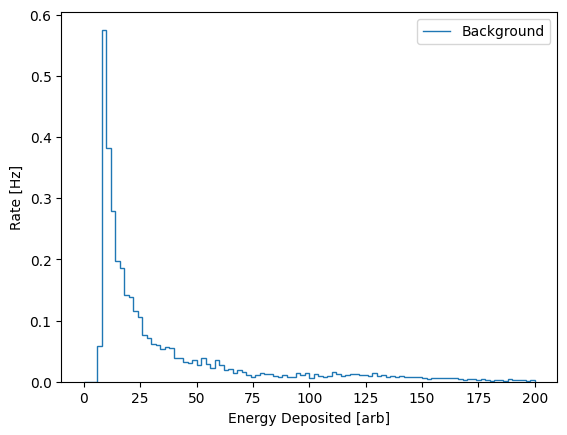

In [ ]:
################################################################################
# You can edit these numbers if you like, but the defaults should be fine
nbins = 100 # Number of bins in the histogram
xmax = 200 # Maximum energy of the histogram
################################################################################

datasets_to_plot = [bkgd_dataset]
dataset_labels = ['Background']
plot_radioactive_energy_spectra(datasets_to_plot, dataset_labels, nbins, xmax)

This type of plot is know as a histogram. It's basically a bar graph with the bar smushed together. This type of histogram is known as an **energy spectrum**. Plotting the energy spectrum measured by a detector is a common way to identify different sources of radiation.

For example, the first plot shown below is from potassium-40, a type of potassium commonly found in bananas. The second plot is plutonium-239, which is used to make nuclear weapons. It would be good to be able to tell the difference!

![](https://github.com/Harvard-Neutrino/IceCube_MasterClass_at_Harvard2025/blob/main/cosmic_watch_activities/resources/K40.png?raw=1)
![](https://github.com/Harvard-Neutrino/IceCube_MasterClass_at_Harvard2025/blob/main/cosmic_watch_activities/resources/Pu239.png?raw=1)


Now, let's make a measurement of some radioactive signal!

Take the plastic bag with the piece of orange plate out of your box. ***Do not remove the plate from the plastic bag!!!***

Place the bag directly on top of the CosmicWatch and take another measurement. As before, make sure to note the filename below and make sure the data run is at least three minutes long. Then, upload the file and change the cell below to take a look at the energy spectrum from the dinner plate.

In [ ]:
################################################################################
# Edit me:
source_filename = 'high_rate_plate.txt'

In [ ]:
# Load in CSV file to the Jupyter notebook
################################################################################
source_dataset = load_data(source_filename)

In [ ]:
# Let's calculate the signal rate:
signal_rate = len(source_dataset) / np.max(source_dataset["Time"])

print( "Background rate: ", bkgd_rate * 60, "particles / minute" )
print( "Signal rate: ", signal_rate * 60, "particles / minute" )

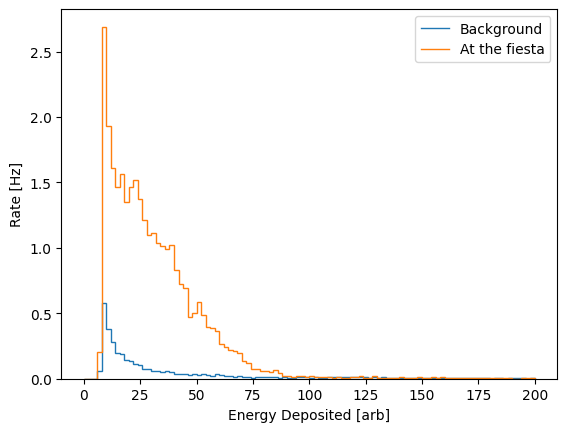

In [ ]:
################################################################################
# You can edit these numbers if you like, but the defaults should be fine
nbins = 100 # Number of bins in the histogram
xmax = 200 # Maximum energy of the histogram
################################################################################

datasets_to_plot = [bkgd_dataset, source_dataset]
dataset_labels = ['Background', 'At the fiesta']
plot_radioactive_energy_spectra(datasets_to_plot, dataset_labels, nbins, xmax)

We can see from both the calculation and the plot that the rate with the plate is definitely higher than the background rate.

Clearly, the plate is relatively radioactive. Can we go further, and learn anything about the particles produced by the plate? Let's take a look at the *shape* of the energy spectrum, by scaling down the two spectra so they are more comparable:

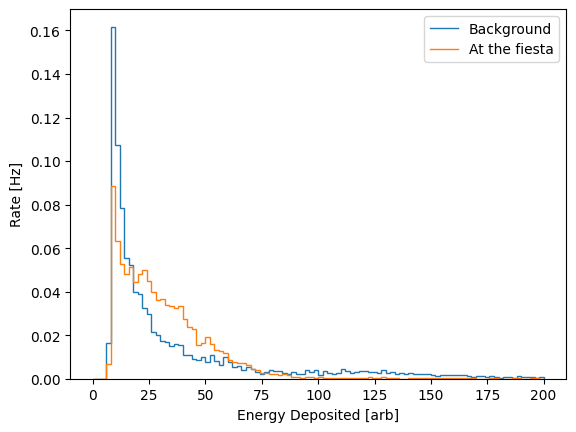

In [ ]:
################################################################################
# You can edit these numbers if you like, but the defaults should be fine
nbins = 100 # Number of bins in the histogram
xmax = 200 # Maximum energy of the histogram
################################################################################

datasets_to_plot = [bkgd_dataset, source_dataset]
dataset_labels = ['Background', 'At the fiesta']
plot_radioactive_energy_spectra(datasets_to_plot, dataset_labels, nbins, xmax, normalize=True)

Describe the shape of the "at the fiesta" energy spectrum. What energies did most of the particles deposit? (Give a range). How does this compare to the background spectrum? Are there any other differences you can observe?


Any idea why this could be?


As another example, here's what the spectrum of something else I measured looks like compared with your measurements. I call it "Cs-137". Any idea what that is?


What do you think makes up the background radiation?

In [ ]:
# Write your answers here!
"""
I think ....

"""

In [ ]:
# Load in CSV file to the Jupyter notebook
################################################################################
# Edit me:
Cs137_filename = 'Cs137.txt'
################################################################################

Cs137_dataset = load_data(Cs137_filename)

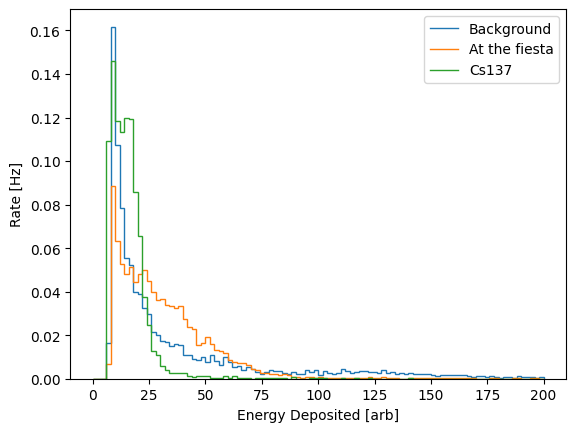

In [ ]:
################################################################################
# You can edit these numbers if you like, but the defaults should be fine
nbins = 100 # Number of bins in the histogram
xmax = 200 # Maximum energy of the histogram
################################################################################

datasets_to_plot = [bkgd_dataset, source_dataset, Cs137_dataset]
dataset_labels = ['Background', 'At the fiesta', 'Cs137']
plot_radioactive_energy_spectra(datasets_to_plot, dataset_labels, nbins, xmax, normalize=True)

That's all for Activty 1. You should now have a pretty good idea of how to use the CosmicWatch. Let's wait for everyone to finish up and then we can discuss our results.

# Activity 2: Muon Coincidence
## Part 1: Downgoing Muons

Let's use our CosmicWatches to detect some muons! Remember, to see the muons we need to filter out the radioactive backgrounds. We do this by looking for **coincident events**. Your CosmicWatches have a special feature where they can be connected to each other so they can communicate. This lets one CosmicWatch tell the other if it saw an event.

To setup the coincidence feature, make sure both of your CosmicWatches are unplugged. Connect the two CosmicWatches using an Ethernet cable and stack them on top of each other, as shown in the cartoon below. Then, plug in one of the CosmicWatches.

For this measurement, we want to measure muons that are coming straight downwards, so make sure your CosmicWatch stack is on a flat surface.

![](https://github.com/Harvard-Neutrino/IceCube_MasterClass_at_Harvard2025/blob/main/cosmic_watch_activities/resources/cw_stack_hamburger.png?raw=1)


Once the CosmicWatches start taking data, you should see a new value on your screen: the number and rate of detected muons. Also, each time the blue LED flashes, your CosmicWatch pair detected a muon!

As before, write down the filename where the data is being stored. For this first measurement, you should take data for about four minutes. After that, upload your data to Colab and run the cells below to take a look at your data.

In [ ]:
################################################################################
# Edit me:
filename_0degree = '0deg.txt'
################################################################################

In [ ]:
# Load dataset
dataset_0deg_full = load_data(filename_0degree)

Now, let's take a look at the energy spectrum of our muons! Below, we will plot three things:


1.   The energy spectrum of the full dataset (all events)
2.   The energy spetrum of coincident events (muons)
3.   The energy spectrum of anti-coincident events (radioactive backgrounds)

Let's take a look!



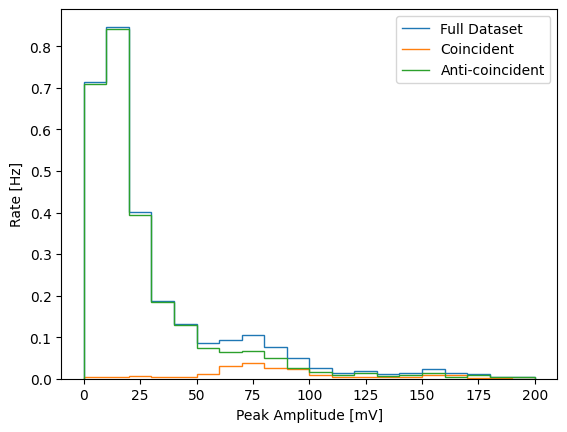

In [ ]:
################################################################################
# You can edit these numbers if you like, but the defaults should be fine
nbins = 20 # Number of bins in the histogram
xmax = 200 # Maximum energy of the histogram
################################################################################

plot_coincidence_comparison_energy_spectra(dataset_0deg_full, nbins, xmax, log_scale=False)

Hm, well that's sort of unfortunate. It looks like we are indeed able to detect muons, but they're hard to see because of the big radioactive peak at low energies. What if we zoom way in on the y-axis?

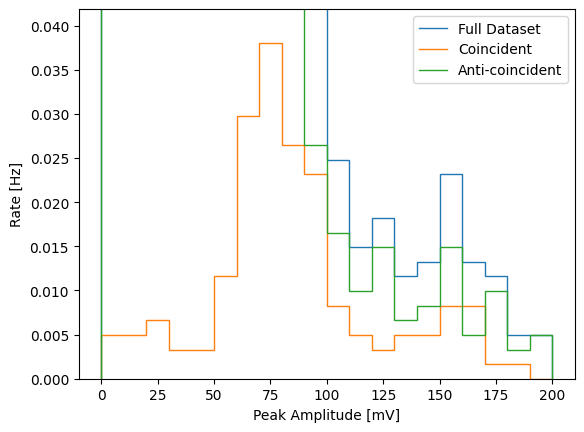

In [ ]:
plot_coincidence_comparison_energy_spectra(dataset_0deg_full, nbins, xmax, log_scale=False, zoom_to_muons=True)

Okay! Now we can see the muons... and not much else. What if we want to be able to see both the shape of the muon spectrum *and* the shape of the background spectrum at the same time? For this we can use a logarithmic plot, often just called a log plot. Log plots are useful to visualize phenomena that occur at very different values.

Most plots you've probably seen have a linear y-axis scale. This means that as you go up in axis ticks, you add a fixed value. This means the axis values will be something like 1,2,3,... The plot above has a linear y-axis scale.

In contrast, to get from one tick to another on a log plot, you *multiply* by a constant value, typically 10. This means the axis values will be something like 1,10,100,... Let's take a look at a log plot of your data!

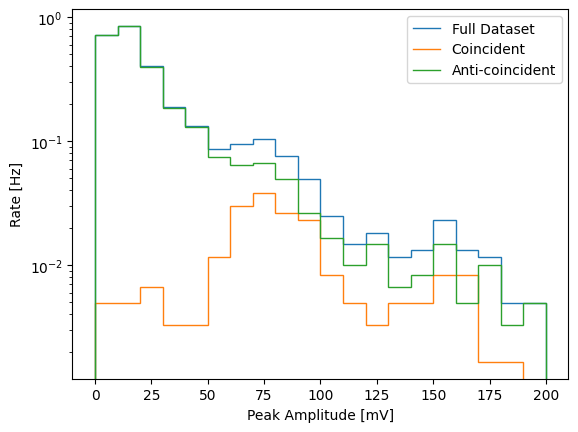

In [ ]:
plot_coincidence_comparison_energy_spectra(dataset_0deg_full, nbins, xmax, log_scale=True, zoom_to_muons=False)

Nice! Now we can see all the spectra at once. What do you notice about the muon spectrum that is different than the radioactive backgrounds? Type in your thoughts below:

In [ ]:
# Write your answers here!
"""
I think ....

"""

And what's the measured muon rate?

In [ ]:
muon_rate_0deg = compute_muon_rate(dataset_0deg_full, print_output=True);

The measured muon rate at 0° is 0.205 +/- 0.018


## Part 2: Angled Muons
Something about measuring at angles.

In [ ]:
################################################################################
# Edit me:
angle_2_in_degrees = 45
filename_angle_2 = '0deg.txt'

angle_3_in_degrees = 60
filename_angle_3 = '0deg.txt'
################################################################################

In [ ]:
# Load datasets
dataset_angle_2 = load_data(filename_angle_2)
dataset_angle_3 = load_data(filename_angle_3)

# Compute muon rates
muon_rate_angle_2 = compute_muon_rate(dataset_angle_2, print_output=True)
muon_rate_angle_3 = compute_muon_rate(dataset_angle_3, print_output=True)

The measured muon rate at 0° is 0.205 +/- 0.018
The measured muon rate at 0° is 0.205 +/- 0.018


Let's take a look at how the muon rate changes at different angles!

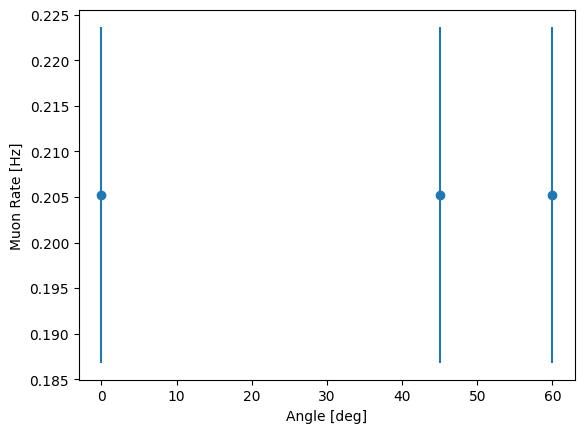

In [ ]:
angles = [0, angle_2_in_degrees, angle_3_in_degrees]
rates = [muon_rate_0deg, muon_rate_angle_2, muon_rate_angle_3]
plot_rate_vs_angle(angles, rates)

Something about the general shape

Of course, there's more than one way you could stack your CosmicWatches. You could also do something like this:

![](https://github.com/Harvard-Neutrino/IceCube_MasterClass_at_Harvard2025/blob/main/cosmic_watch_activities/resources/cw_stack_hotdog.png?raw=1)


How do you think the rate would change if you stacked them like this instead of what you did before? Fill in your guess, in terms of percent, in the cell below. For example, 100% would mean that the rate is the same, whereas a rate of 150% would mean a 1 Hz rate would now be 1.5 Hz.

As a hint, here's the engineering diagram for the scintillator inside your CosmicWatch:

![](https://github.com/Harvard-Neutrino/IceCube_MasterClass_at_Harvard2025/blob/main/cosmic_watch_activities/resources/scintillator_cad.png?raw=1)

In [ ]:
################################################################################
# Fill in your guess here:
guessed_rate_change_in_percent = 97
################################################################################

Go ahead and make a measurement in this new configuration to see how close your guess was. We saw earlier that the rate is highest for muons go straight downwards, so setup your CosmicWatch stack to measure muons that go straight downwards so we can make the measurement as efficiently (as fast) as possible. After your measurement, upload your code as before and run the cells below.

In [ ]:
################################################################################
# Edit me:
filename_vertical_stack = '0deg.txt'
################################################################################

In [ ]:
# Load data
dataset_vertical_stack = load_data(filename_vertical_stack)

# Calculate muon rate
muon_rate_vertical_stack = compute_muon_rate(dataset_vertical_stack, print_output=True)

print(f'This corresponds to a change of {100*muon_rate_vertical_stack[0]/muon_rate_0deg[0]}%')
print(f'As a reminder, you guessed {guessed_rate_change_in_percent}%.')

The measured muon rate at 0° is 0.205 +/- 0.018
This corresponds to a change of 100.0%
As a reminder, you guessed 97%.


The rate is substantially low in this configuration. Can you think of a reason you'd want to measure using this orientation instead of the one we did initially?

In [ ]:
# Write your answers here!
"""
I think ....

"""